## OK Cupid Classification

Initialize libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC #support vector machines
from sklearn.naive_bayes import BernoulliNB #, GaussianNB, MultinomialNB #Naive Bayes
from sklearn import metrics #Model evaulation
#import seaborn as sns
%matplotlib inline

Load OKCupid data from csv file.
Convert all question responses from text to integer values.
(But Save the mapping from text question responses to integers for later use)

In [28]:
#Load data
userdata = pd.read_csv('user_data_public.csv',low_memory=False)

#Replace all NaNs with 0s
userdata.replace(np.nan,0,inplace=True)

#Create a list of all question columns, to be used as an index
question_column_names = []
for column_name, column_series in userdata.iteritems():
    if column_name[0] == 'q': #Take only question columns
        question_column_names.append(column_name) #Add these names to a list

#Replace each column of question response data (currently text values) with a set of integer values (0,1,2, etc.)
#Also, store mappings between those set values and the original text to a new dataframe
userdata_recode = pd.DataFrame.copy(userdata) #create a copy of this that replaces all question responses with numerical values 1-4 (would need to do this by looking up values from the question list, returning the column #)
question_answers = pd.DataFrame('Blank',index=question_column_names,columns=['0','1','2','3','4'])
for column_name, column_series in userdata.iteritems(): #Iterate through columns 
    if column_name != 'd_age': #d_age is the only column with meaningful numbers (don't replace!)
        new_series = column_series
        new_series_set = pd.Series(list(set(new_series))) #Order is different from the set!
        new_column = pd.Series.copy(new_series) #Start out by making new_column a copy of column_series  
        for value in new_series_set:
            new_column.loc[new_column == value] = new_series_set[new_series_set == value].index[0] #This is selecting all rows in new_colum where the value equals the current text value from new_series_set, and replacing with the index from new_series_set
        userdata_recode[column_name] = new_column
        if column_name[0] == 'q':
            for index, value in enumerate(new_series_set):
                question_answers.ix[column_name,str(index)] = value

#Add a column for each user with counts of how many questions they gave non-zero responses to (caveat: min value is 5 for userdata, and 20 for userdata_recode, so something funny is going on)
userdata_recode['Answered_count'] = userdata_recode[userdata_recode[question_column_names] > 0].count(axis=1)

Plot histograms of # of questions answered by user. (Not all users answered all questions, and many thousands barely answered any)

Full dataset: 68371 users


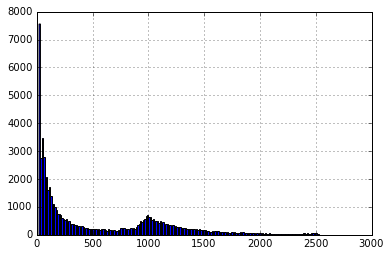

Reduced dataset: 28704 users


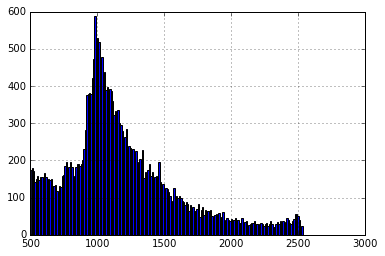

In [39]:
#Show histogram for full dataset:
full_count = len(userdata_recode)
print 'Full dataset: ' + str(full_count) + ' users'
userdata_recode['Answered_count'].hist(bins=200) #Plot histograms of this
plt.show()

#(Optional step) Remove users who haven't answered very many questions:
min_answered = 500 #Original count = 68371; N=500 --> 28704; N=1000 --> 18390
userdata_recode = userdata_recode[userdata_recode['Answered_count'] >= min_answered]
reduced_count = len(userdata_recode)
print 'Reduced dataset: ' + str(reduced_count) + ' users'
userdata_recode['Answered_count'].hist(bins=200) #Plot histograms of this
plt.show()

Add a column that is a random sampling of 1 vs 2 (or 1 vs 0) - this will serve as a control (classification should not work for this)

In [40]:
userdata_recode['Control'] = np.random.randint(1,high=3,size=userdata_recode.shape[0]) #Random integers of values 1 or 2

Create new columns setting 2 classes for each to-be-classified feature

In [41]:
num_features = 9
label_mappings = pd.DataFrame(0,index=np.arange(num_features),columns=[0,1,2])
feature_names = pd.Series('Blank',index=np.arange(num_features))

0) GENDER: HETERO FEMALE vs. HETERO MALE

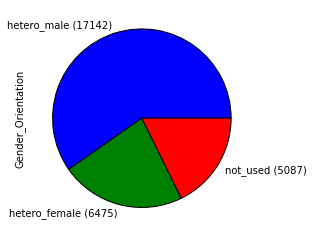

q32855  Divergence factor: 0.717621007176


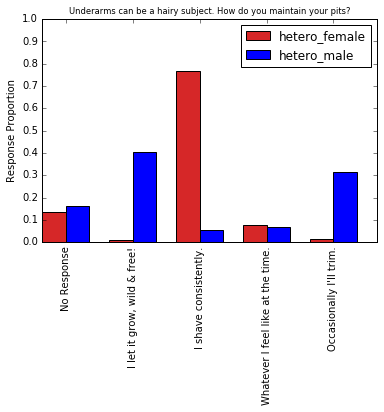

q13669  Divergence factor: 0.621956070777


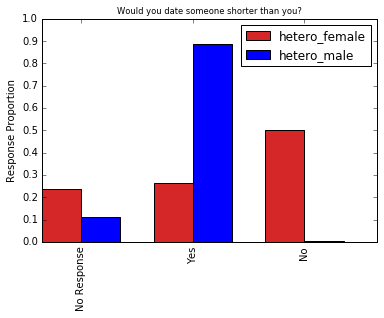

q66544  Divergence factor: 0.619975079835


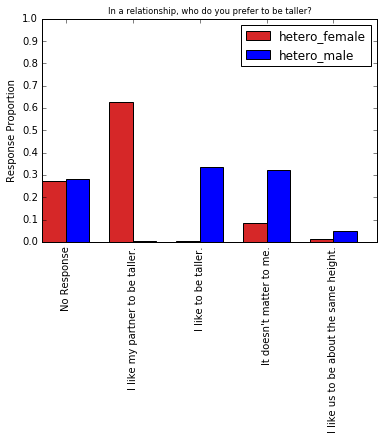

q65043  Divergence factor: 0.541916519249


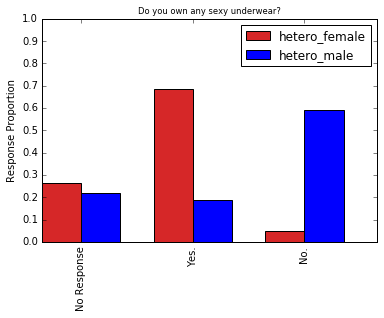

q463  Divergence factor: 0.505955901399


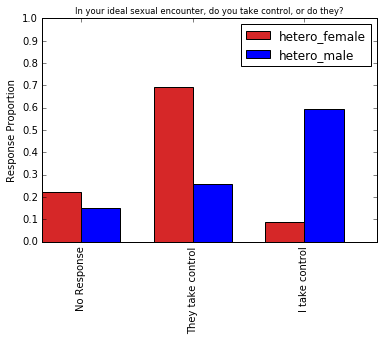

In [55]:
#Create a column that identifies each user as either Hetero Female, Hetero Male, or Other
#Later we will train and run classifier on Hetero Female vs. Hetero Male
feature_index = 0
orig_feature_name = 'gender_orientation'
feature_name = 'Gender_Orientation'
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name]))) #Use this to manually set values in class_1 and class_2
label_mappings.ix[feature_index] = ['not_used', 'hetero_female', 'hetero_male'] #0,1,2
class_1 = [1] #Hetero_female
class_2 = [5] #Hetero_male
new_column = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
for class_num in [1,2]:
    if class_num == 1:
        for current_val in class_1: 
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    elif class_num == 2:
        for current_val in class_2:
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    userdata_recode[feature_names.ix[feature_index]] = new_column
    
#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')'))
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))
plt.show()
    
#Calculate which questions have the most divergent answers for these classes:
diff_scores = pd.Series(0.0,index=question_column_names)
count_column_name = 'd_age' #This is the column that is counted in the pivot_table; doesn't matter which column
for question_column_name in question_column_names:
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    diff_score = abs(table_proportions.ix[1] - table_proportions.ix[2]).sum()/2 #Calculate % diff, save to a series
    diff_scores[question_column_name] = diff_score
diff_scores.sort_values(ascending=False,inplace=True) #Sort series by % diff; for dataframe, use: diff_table.sort_values(by='diff_scores',ascending=False, inplace=True)
    
#Now repeat above for just the top 5 questions, and plot each:
num_questions_to_plot = 5
question_text = ['Underarms can be a hairy subject. How do you maintain your pits?', 'Would you date someone shorter than you?', 'In a relationship, who do you prefer to be taller?', 'Do you own any sexy underwear?', 'In your ideal sexual encounter, do you take control, or do they?']
for question_num in range(num_questions_to_plot):
    question_diff_score = diff_scores[question_num] #Pull out most divergent questions, in descending order
    question_column_name = diff_scores.index[question_num] #Pull out most divergent questions, in descending order
    print question_column_name + '  Divergence factor: ' + str(question_diff_score)
    num_resp_types = len(set(userdata_recode[question_column_name])) #Number of unique responses possible for each question
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    indices = np.arange(num_resp_types) # the x locations for the groups
    width = 0.35
    p1 = plt.bar(indices, table_proportions.ix[1], width, color='#d62728') #Under 40
    p2 = plt.bar(indices+width, table_proportions.ix[2], width) #40 and Over
    plt.ylabel('Response Proportion')
    plt.title(question_text[question_num], fontsize='small') #The text of the question, from question_data.csv
    plt.xticks(indices+width, ('No Response', question_answers.ix[question_column_name,1], question_answers.ix[question_column_name,2], question_answers.ix[question_column_name,3], question_answers.ix[question_column_name,4]),rotation='vertical') #The actual responses, from question_data.csv
    plt.yticks(np.arange(0, 1.01, .1))
    plt.legend((p1[0], p2[0]), (label_mappings.ix[feature_index][1], label_mappings.ix[feature_index][2]))
    plt.show()

1) AGE: UNDER 40 vs. 40 AND OVER

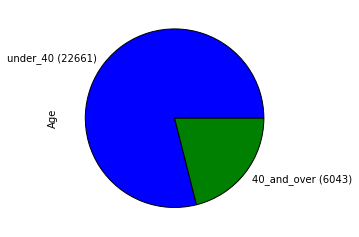

q106  Divergence factor: 0.353443168494


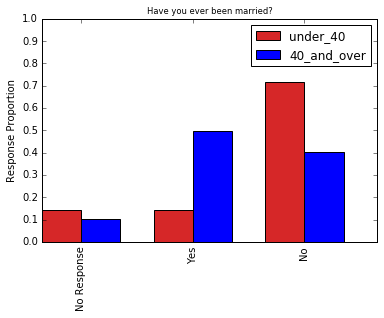

q49053  Divergence factor: 0.34188062936


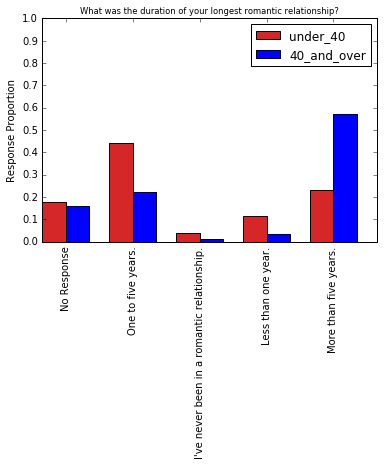

q64239  Divergence factor: 0.302518818713


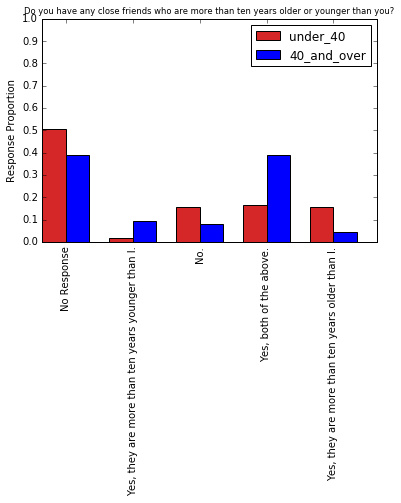

q31920  Divergence factor: 0.30219529116


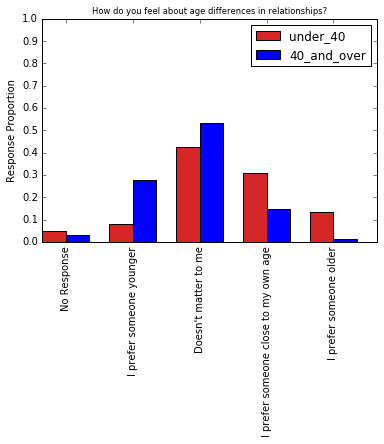

q105  Divergence factor: 0.298945031008


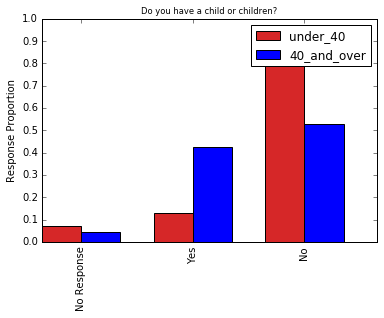

In [56]:
feature_index = 1
orig_feature_name = 'd_age'
feature_name = 'Age'
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name]))) #Use this to manually set values in class_1 and class_2
label_mappings.ix[feature_index] = ['not_used','under_40','40_and_over']
bisect_age = 40 #31 roughly bisects the data
userdata_recode[feature_names.ix[feature_index]] = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
userdata_recode[feature_names.ix[feature_index]].loc[userdata_recode[orig_feature_name] < bisect_age] = 1
userdata_recode[feature_names.ix[feature_index]].loc[userdata_recode[orig_feature_name] >= bisect_age] = 2

#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
#label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')')) #Blank because everyone has to list an age on OKCupid
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))
plt.show()

#Calculate which questions have the most divergent answers for these classes:
diff_scores = pd.Series(0.0,index=question_column_names)
count_column_name = 'd_age' #This is the column that is counted in the pivot_table; doesn't matter which column
for question_column_name in question_column_names:
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    diff_score = abs(table_proportions.ix[1] - table_proportions.ix[2]).sum()/2 #Calculate % diff, save to a series
    diff_scores[question_column_name] = diff_score
diff_scores.sort_values(ascending=False,inplace=True) #Sort series by % diff; for dataframe, use: diff_table.sort_values(by='diff_scores',ascending=False, inplace=True)

#Now repeat above for just the top 5 questions, and plot each:
num_questions_to_plot = 5
question_text = ['Have you ever been married?', 'What was the duration of your longest romantic relationship?', 'Do you have any close friends who are more than ten years older or younger than you?', 'How do you feel about age differences in relationships?', 'Do you have a child or children?']
for question_num in range(num_questions_to_plot):
    question_diff_score = diff_scores[question_num] #Pull out most divergent questions, in descending order
    question_column_name = diff_scores.index[question_num] #Pull out most divergent questions, in descending order
    print question_column_name + '  Divergence factor: ' + str(question_diff_score)
    num_resp_types = len(set(userdata_recode[question_column_name])) #Number of unique responses possible for each question
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    indices = np.arange(num_resp_types) # the x locations for the groups
    width = 0.35
    p1 = plt.bar(indices, table_proportions.ix[1], width, color='#d62728') #Under 40
    p2 = plt.bar(indices+width, table_proportions.ix[2], width) #40 and Over
    plt.ylabel('Response Proportion')
    plt.title(question_text[question_num], fontsize='small') #The text of the question, from question_data.csv
    plt.xticks(indices+width, ('No Response', question_answers.ix[question_column_name,1], question_answers.ix[question_column_name,2], question_answers.ix[question_column_name,3], question_answers.ix[question_column_name,4]),rotation='vertical') #The actual responses, from question_data.csv
    plt.yticks(np.arange(0, 1.01, .1))
    plt.legend((p1[0], p2[0]), (label_mappings.ix[feature_index][1], label_mappings.ix[feature_index][2]))
    plt.show()

2) EDUCATIONAL LEVEL

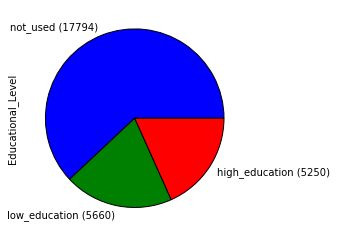

q274  Divergence factor: 0.736548881037


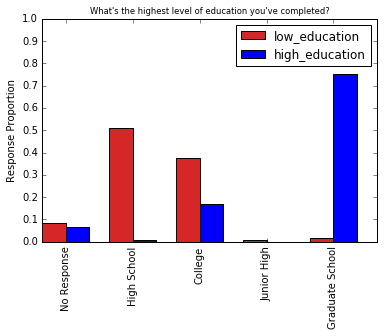

q23305  Divergence factor: 0.399309103147


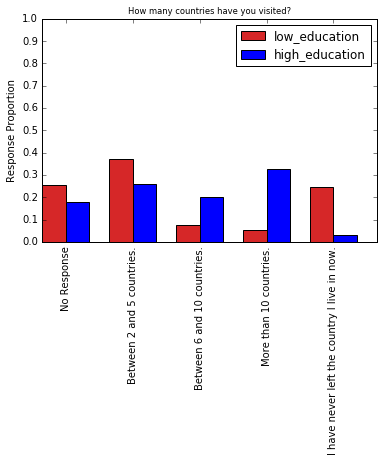

q19265  Divergence factor: 0.343587077234


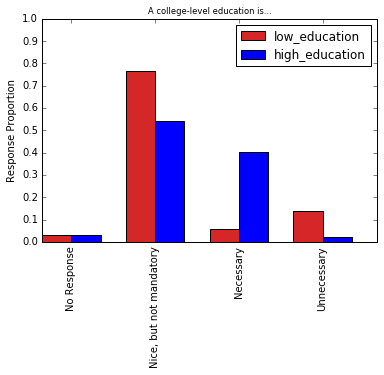

q12796  Divergence factor: 0.334030624264


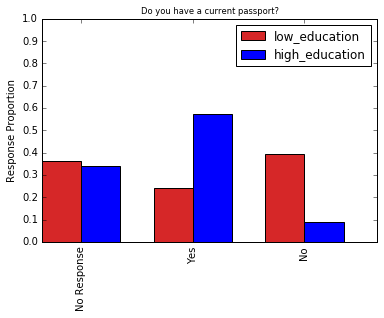

q212813  Divergence factor: 0.329441023052


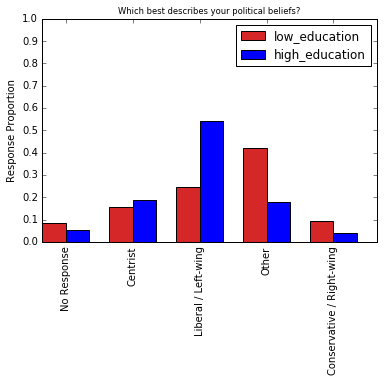

In [58]:
feature_index = 2
orig_feature_name = 'd_education_type'
feature_name = 'Educational_Level'
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name]))) #Use this to manually set values in class_1 and class_2
label_mappings.ix[feature_index] = ['not_used','low_education','high_education']
class_1 = [2,6,10,11] #High school, two-year college, high school, Two-year college ---> low_education
class_2 = [1,4,5,9,12,13,15] #Masters program, Law school, law school, Med school, masters program, med school, Ph.D. program --> high_education
new_column = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
for class_num in [1,2]:
    if class_num == 1:
        for current_val in class_1: 
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    elif class_num == 2:
        for current_val in class_2:
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    userdata_recode[feature_names.ix[feature_index]] = new_column
    
#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')'))
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))
plt.show()

#Calculate which questions have the most divergent answers for these classes:
diff_scores = pd.Series(0.0,index=question_column_names)
count_column_name = 'd_age' #This is the column that is counted in the pivot_table; doesn't matter which column
for question_column_name in question_column_names:
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    diff_score = abs(table_proportions.ix[1] - table_proportions.ix[2]).sum()/2 #Calculate % diff, save to a series
    diff_scores[question_column_name] = diff_score
diff_scores.sort_values(ascending=False,inplace=True) #Sort series by % diff; for dataframe, use: diff_table.sort_values(by='diff_scores',ascending=False, inplace=True)

#Now repeat above for just the top 5 questions, and plot each:
num_questions_to_plot = 5
question_text = ['What\'s the highest level of education you\'ve completed?', 'How many countries have you visited?', 'A college-level education is...', 'Do you have a current passport?', 'Which best describes your political beliefs?']
for question_num in range(num_questions_to_plot):
    question_diff_score = diff_scores[question_num] #Pull out most divergent questions, in descending order
    question_column_name = diff_scores.index[question_num] #Pull out most divergent questions, in descending order
    print question_column_name + '  Divergence factor: ' + str(question_diff_score)
    num_resp_types = len(set(userdata_recode[question_column_name])) #Number of unique responses possible for each question
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    indices = np.arange(num_resp_types) # the x locations for the groups
    width = 0.35
    p1 = plt.bar(indices, table_proportions.ix[1], width, color='#d62728') #Low Ed
    p2 = plt.bar(indices+width, table_proportions.ix[2], width) #High Ed
    plt.ylabel('Response Proportion')
    plt.title(question_text[question_num], fontsize='small') #The text of the question, from question_data.csv
    plt.xticks(indices+width, ('No Response', question_answers.ix[question_column_name,1], question_answers.ix[question_column_name,2], question_answers.ix[question_column_name,3], question_answers.ix[question_column_name,4]),rotation='vertical') #The actual responses, from question_data.csv
    plt.yticks(np.arange(0, 1.01, .1))
    plt.legend((p1[0], p2[0]), (label_mappings.ix[feature_index][1], label_mappings.ix[feature_index][2]))
    plt.show()

3) JOB SECTOR: HIGH vs LOW INCOME

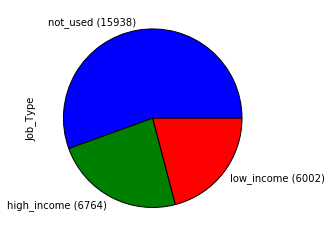

q8865  Divergence factor: 0.360540966928


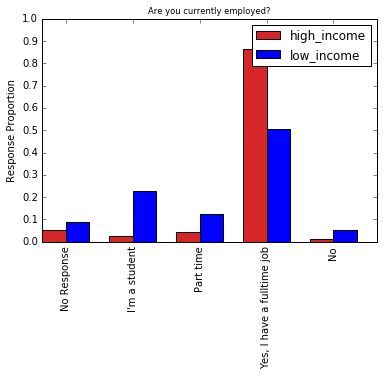

q158  Divergence factor: 0.26425209929


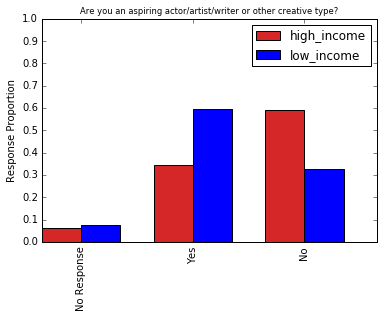

q13136  Divergence factor: 0.213530341059


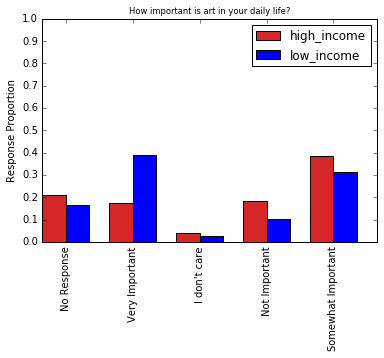

q215  Divergence factor: 0.183873904835


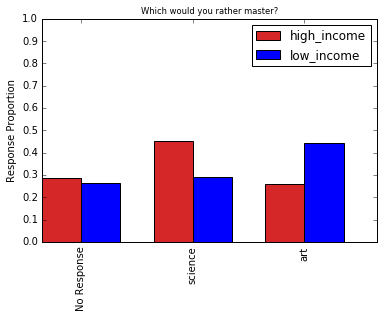

q23477  Divergence factor: 0.177345921161


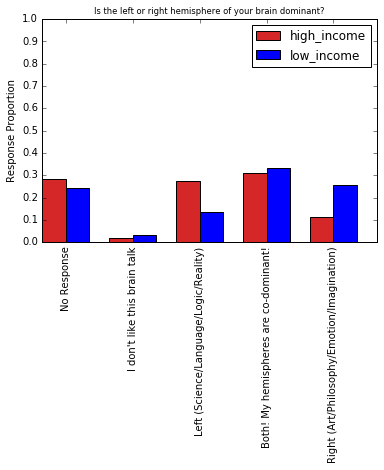

In [60]:
feature_index = 3
orig_feature_name = 'd_job'
feature_name = 'Job_Type'
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name]))) #Use this to manually set values in class_1 and class_2
label_mappings.ix[feature_index] = ['not_used','high_income','low_income']
class_1 = [1,6,12,13,21] #Management, Medicine, Banking/Finance, Law, Technology ---> high_income
class_2 = [7,9,10,11,20] #Art/Music/Writing, Unemployed, Construction, Student, Education --> low_income
new_column = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
for class_num in [1,2]:
    if class_num == 1:
        for current_val in class_1: 
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    elif class_num == 2:
        for current_val in class_2:
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    userdata_recode[feature_names.ix[feature_index]] = new_column
    
#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')'))
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))
plt.show()

#Calculate which questions have the most divergent answers for these classes:
diff_scores = pd.Series(0.0,index=question_column_names)
count_column_name = 'd_age' #This is the column that is counted in the pivot_table; doesn't matter which column
for question_column_name in question_column_names:
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    diff_score = abs(table_proportions.ix[1] - table_proportions.ix[2]).sum()/2 #Calculate % diff, save to a series
    diff_scores[question_column_name] = diff_score
diff_scores.sort_values(ascending=False,inplace=True) #Sort series by % diff; for dataframe, use: diff_table.sort_values(by='diff_scores',ascending=False, inplace=True)

#Now repeat above for just the top 5 questions, and plot each:
num_questions_to_plot = 5
question_text = ['Are you currently employed?', 'Are you an aspiring actor/artist/writer or other creative type?', 'How important is art in your daily life?', 'Which would you rather master?', 'Is the left or right hemisphere of your brain dominant?']
for question_num in range(num_questions_to_plot):
    question_diff_score = diff_scores[question_num] #Pull out most divergent questions, in descending order
    question_column_name = diff_scores.index[question_num] #Pull out most divergent questions, in descending order
    print question_column_name + '  Divergence factor: ' + str(question_diff_score)
    num_resp_types = len(set(userdata_recode[question_column_name])) #Number of unique responses possible for each question
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    indices = np.arange(num_resp_types) # the x locations for the groups
    width = 0.35
    p1 = plt.bar(indices, table_proportions.ix[1], width, color='#d62728') #High Income
    p2 = plt.bar(indices+width, table_proportions.ix[2], width) #Low Income
    plt.ylabel('Response Proportion')
    plt.title(question_text[question_num], fontsize='small') #The text of the question, from question_data.csv
    plt.xticks(indices+width, ('No Response', question_answers.ix[question_column_name,1], question_answers.ix[question_column_name,2], question_answers.ix[question_column_name,3], question_answers.ix[question_column_name,4]),rotation='vertical') #The actual responses, from question_data.csv
    plt.yticks(np.arange(0, 1.01, .1))
    plt.legend((p1[0], p2[0]), (label_mappings.ix[feature_index][1], label_mappings.ix[feature_index][2]))
    plt.show()

4) BODY TYPE: IDEAL vs NONIDEAL

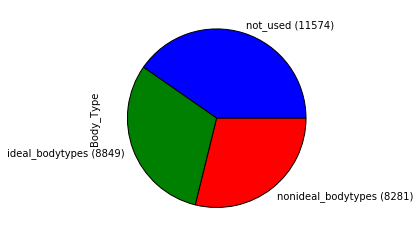

q6350  Divergence factor: 0.741327549669


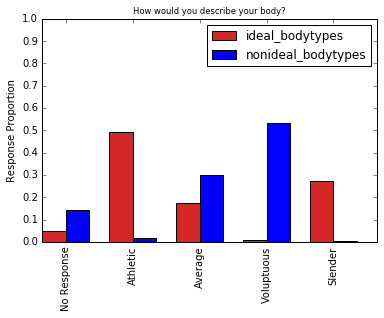

q52682  Divergence factor: 0.455596233054


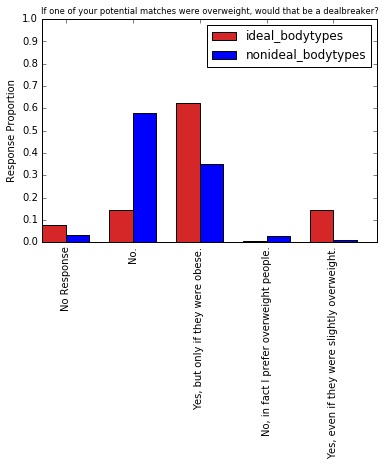

q126  Divergence factor: 0.440017107867


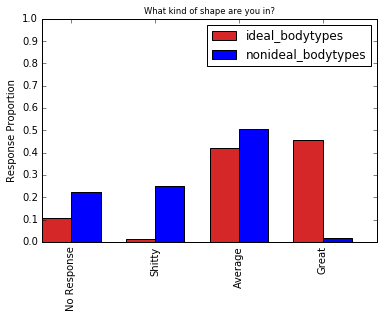

q132  Divergence factor: 0.430684270049


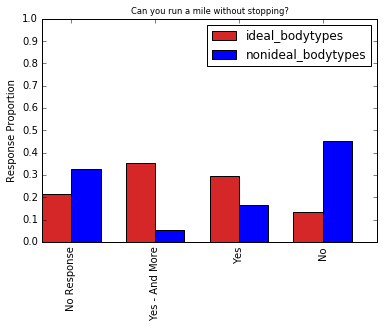

q122  Divergence factor: 0.351301974797


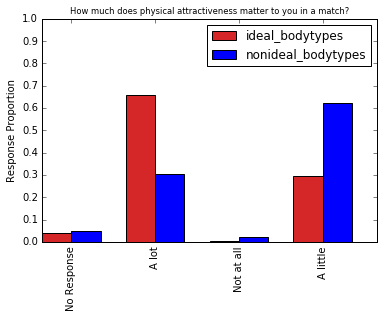

In [62]:
feature_index = 4
orig_feature_name = 'd_bodytype'
feature_name = 'Body_Type'
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name]))) #Use this to manually set values in class_1 and class_2
label_mappings.ix[feature_index] = ['not_used','ideal_bodytypes','nonideal_bodytypes']
class_1 = [1,3,4,10,12] #Jacked, Fit, Athletic, Thin, Skinny --> ideal_bodytypes
class_2 = [5,7,8,9,11] #Used up, Full figured, Overweight, Curvy, A little extra --> nonideal_bodytypes
new_column = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
for class_num in [1,2]:
    if class_num == 1:
        for current_val in class_1: 
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    elif class_num == 2:
        for current_val in class_2:
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    userdata_recode[feature_names.ix[feature_index]] = new_column
    
#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')'))
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))
plt.show()

#Calculate which questions have the most divergent answers for these classes:
diff_scores = pd.Series(0.0,index=question_column_names)
count_column_name = 'd_age' #This is the column that is counted in the pivot_table; doesn't matter which column
for question_column_name in question_column_names:
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    diff_score = abs(table_proportions.ix[1] - table_proportions.ix[2]).sum()/2 #Calculate % diff, save to a series
    diff_scores[question_column_name] = diff_score
diff_scores.sort_values(ascending=False,inplace=True) #Sort series by % diff; for dataframe, use: diff_table.sort_values(by='diff_scores',ascending=False, inplace=True)

#Now repeat above for just the top 5 questions, and plot each:
num_questions_to_plot = 5
question_text = ['How would you describe your body?', 'If one of your potential matches were overweight, would that be a dealbreaker?', 'What kind of shape are you in?', 'Can you run a mile without stopping?', 'How much does physical attractiveness matter to you in a match?']
for question_num in range(num_questions_to_plot):
    question_diff_score = diff_scores[question_num] #Pull out most divergent questions, in descending order
    question_column_name = diff_scores.index[question_num] #Pull out most divergent questions, in descending order
    print question_column_name + '  Divergence factor: ' + str(question_diff_score)
    num_resp_types = len(set(userdata_recode[question_column_name])) #Number of unique responses possible for each question
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    indices = np.arange(num_resp_types) # the x locations for the groups
    width = 0.35
    p1 = plt.bar(indices, table_proportions.ix[1], width, color='#d62728') #Ideal
    p2 = plt.bar(indices+width, table_proportions.ix[2], width) #Nonideal
    plt.ylabel('Response Proportion')
    plt.title(question_text[question_num], fontsize='small') #The text of the question, from question_data.csv
    plt.xticks(indices+width, ('No Response', question_answers.ix[question_column_name,1], question_answers.ix[question_column_name,2], question_answers.ix[question_column_name,3], question_answers.ix[question_column_name,4]),rotation='vertical') #The actual responses, from question_data.csv
    plt.yticks(np.arange(0, 1.01, .1))
    plt.legend((p1[0], p2[0]), (label_mappings.ix[feature_index][1], label_mappings.ix[feature_index][2]))
    plt.show()

5) DRUG USE: NO vs YES

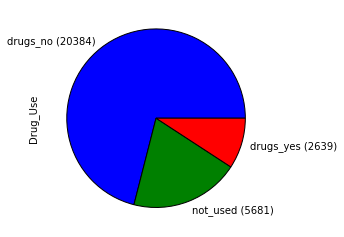

q25228  Divergence factor: 0.709829886862


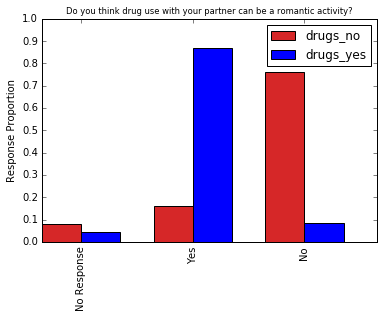

q79  Divergence factor: 0.703494627294


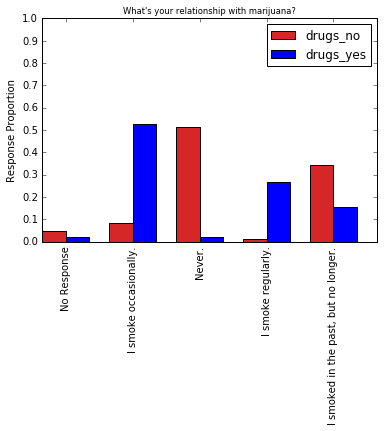

q15414  Divergence factor: 0.612202606507


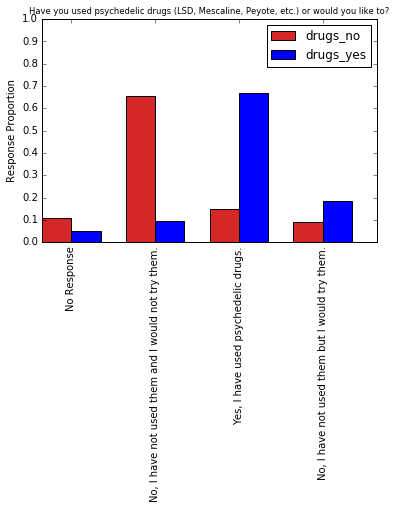

q62254  Divergence factor: 0.610072808964


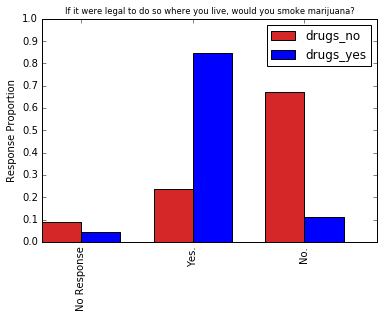

q80  Divergence factor: 0.605434282466


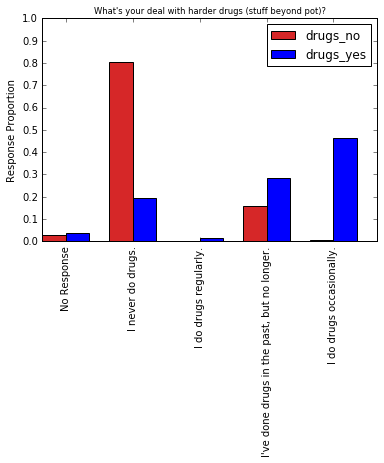

In [64]:
feature_index = 5
orig_feature_name = 'd_drugs' #Original name
feature_name = 'Drug_Use' #New name
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name])))  #Use this to manually set values in class_1 and class_2
label_mappings.ix[feature_index] = ['not_used','drugs_no', 'drugs_yes']
class_1 = [1] #Never --> drugs_no
class_2 = [2,3] #Often, Sometimes --> drugs_yes
new_column = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
for class_num in [1,2]:
    if class_num == 1:
        for current_val in class_1: 
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    elif class_num == 2:
        for current_val in class_2:
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    userdata_recode[feature_names.ix[feature_index]] = new_column

#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')'))
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))
plt.show()

#Calculate which questions have the most divergent answers for these classes:
diff_scores = pd.Series(0.0,index=question_column_names)
count_column_name = 'd_age' #This is the column that is counted in the pivot_table; doesn't matter which column
for question_column_name in question_column_names:
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    diff_score = abs(table_proportions.ix[1] - table_proportions.ix[2]).sum()/2 #Calculate % diff, save to a series
    diff_scores[question_column_name] = diff_score
diff_scores.sort_values(ascending=False,inplace=True) #Sort series by % diff; for dataframe, use: diff_table.sort_values(by='diff_scores',ascending=False, inplace=True)

#Now repeat above for just the top 5 questions, and plot each:
num_questions_to_plot = 5
question_text = ['Do you think drug use with your partner can be a romantic activity?', 'What\'s your relationship with marijuana?', 'Have you used psychedelic drugs (LSD, Mescaline, Peyote, etc.) or would you like to?', 'If it were legal to do so where you live, would you smoke marijuana?', 'What\'s your deal with harder drugs (stuff beyond pot)?']
for question_num in range(num_questions_to_plot):
    question_diff_score = diff_scores[question_num] #Pull out most divergent questions, in descending order
    question_column_name = diff_scores.index[question_num] #Pull out most divergent questions, in descending order
    print question_column_name + '  Divergence factor: ' + str(question_diff_score)
    num_resp_types = len(set(userdata_recode[question_column_name])) #Number of unique responses possible for each question
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    indices = np.arange(num_resp_types) # the x locations for the groups
    width = 0.35
    p1 = plt.bar(indices, table_proportions.ix[1], width, color='#d62728') #No Drugs
    p2 = plt.bar(indices+width, table_proportions.ix[2], width) #Drugs
    plt.ylabel('Response Proportion')
    plt.title(question_text[question_num], fontsize='small') #The text of the question, from question_data.csv
    plt.xticks(indices+width, ('No Response', question_answers.ix[question_column_name,1], question_answers.ix[question_column_name,2], question_answers.ix[question_column_name,3], question_answers.ix[question_column_name,4]),rotation='vertical') #The actual responses, from question_data.csv
    plt.yticks(np.arange(0, 1.01, .1))
    plt.legend((p1[0], p2[0]), (label_mappings.ix[feature_index][1], label_mappings.ix[feature_index][2]))
    plt.show()

6) LOCATION: NY vs CA

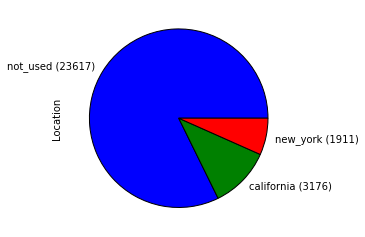

q35564  Divergence factor: 0.336072347947


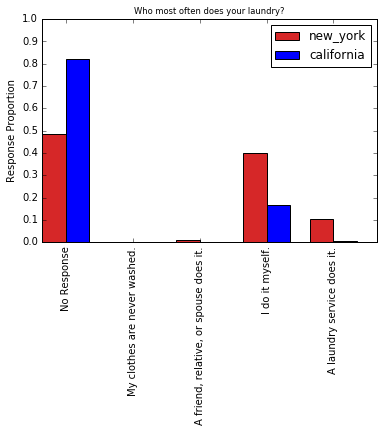

q2717  Divergence factor: 0.229371549046


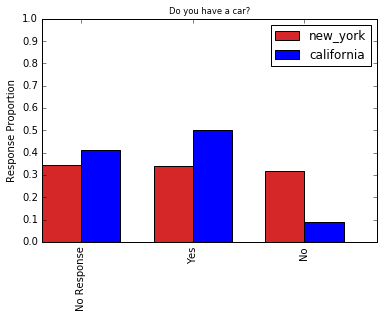

q44354  Divergence factor: 0.186876949966


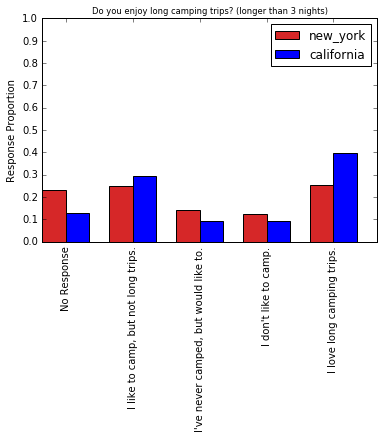

q9446  Divergence factor: 0.184799127944


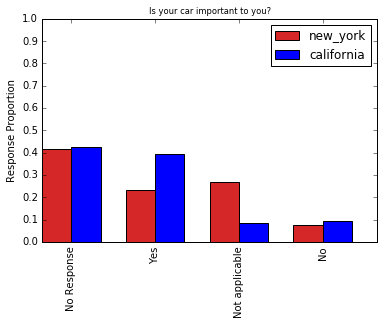

q153  Divergence factor: 0.170706153029


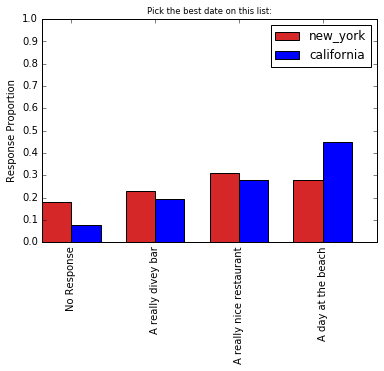

In [66]:
feature_index = 6
orig_feature_name = 'd_country'
feature_name = 'Location'
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name])))
label_mappings.ix[feature_index] = ['not_used','new_york','california']
class_1 = [117]
class_2 = [173]
new_column = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
for class_num in [1,2]:
    if class_num == 1:
        for current_val in class_1: 
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    elif class_num == 2:
        for current_val in class_2:
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    userdata_recode[feature_names.ix[feature_index]] = new_column

#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')'))
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))
plt.show()

#Calculate which questions have the most divergent answers for these classes:
diff_scores = pd.Series(0.0,index=question_column_names)
count_column_name = 'd_age' #This is the column that is counted in the pivot_table; doesn't matter which column
for question_column_name in question_column_names:
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    diff_score = abs(table_proportions.ix[1] - table_proportions.ix[2]).sum()/2 #Calculate % diff, save to a series
    diff_scores[question_column_name] = diff_score
diff_scores.sort_values(ascending=False,inplace=True) #Sort series by % diff; for dataframe, use: diff_table.sort_values(by='diff_scores',ascending=False, inplace=True)

#Now repeat above for just the top 5 questions, and plot each:
num_questions_to_plot = 5
question_text = ['Who most often does your laundry?', 'Do you have a car?', 'Do you enjoy long camping trips? (longer than 3 nights)', 'Is your car important to you?', 'Pick the best date on this list:']
for question_num in range(num_questions_to_plot):
    question_diff_score = diff_scores[question_num] #Pull out most divergent questions, in descending order
    question_column_name = diff_scores.index[question_num] #Pull out most divergent questions, in descending order
    print question_column_name + '  Divergence factor: ' + str(question_diff_score)
    num_resp_types = len(set(userdata_recode[question_column_name])) #Number of unique responses possible for each question
    table = userdata_recode.pivot_table(count_column_name, index=feature_name, columns=question_column_name, aggfunc='count') #Create a pivot table of each question x class
    table_proportions = pd.DataFrame(0,index=table.index,columns=table.columns)
    for row_index, row_data in table.iterrows():
        table_proportions.ix[row_index] = row_data / row_data.sum()
    indices = np.arange(num_resp_types) # the x locations for the groups
    width = 0.35
    p1 = plt.bar(indices, table_proportions.ix[1], width, color='#d62728') #NY
    p2 = plt.bar(indices+width, table_proportions.ix[2], width) #CA
    plt.ylabel('Response Proportion')
    plt.title(question_text[question_num], fontsize='small') #The text of the question, from question_data.csv
    plt.xticks(indices+width, ('No Response', question_answers.ix[question_column_name,1], question_answers.ix[question_column_name,2], question_answers.ix[question_column_name,3], question_answers.ix[question_column_name,4]),rotation='vertical') #The actual responses, from question_data.csv
    plt.yticks(np.arange(0, 1.01, .1))
    plt.legend((p1[0], p2[0]), (label_mappings.ix[feature_index][1], label_mappings.ix[feature_index][2]))
    plt.show()

7) ASTROLOGY SIGN: (SHOULD ALSO BE A CONTROL; Virgo vs. Aquarius)

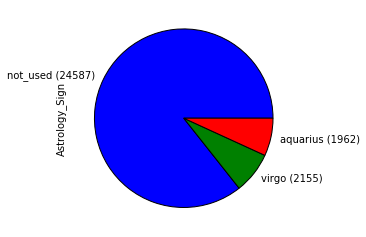

In [67]:
feature_index = 7
orig_feature_name = 'd_astrology_sign'
feature_name = 'Astrology_Sign'
feature_names.ix[feature_index] = feature_name
#labels_set = pd.Series(list(set(userdata[orig_feature_name]))) #Use this to manually set values in class_1 and class_2
label_mappings.ix[feature_index] = ['not_used','virgo', 'aquarius']
class_1 = [8] #Virgo
class_2 = [4] #Aquarius
new_column = pd.Series(0, index=userdata_recode.index) #Start out by making new_column a copy of column_series
for class_num in [1,2]:
    if class_num == 1:
        for current_val in class_1: 
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    elif class_num == 2:
        for current_val in class_2:
            new_column.loc[userdata_recode[orig_feature_name] == current_val] = class_num
    userdata_recode[feature_names.ix[feature_index]] = new_column
    
#Plot a pie chart illustrating the counts of users in each category
class_counts = userdata_recode[feature_name].value_counts()
label_0 = (str(label_mappings.ix[feature_index][0])+str(' (')+str(class_counts[0])+str(')'))
label_1 = (str(label_mappings.ix[feature_index][1])+str(' (')+str(class_counts[1])+str(')'))
label_2 = (str(label_mappings.ix[feature_index][2])+str(' (')+str(class_counts[2])+str(')'))
class_counts.rename({0:label_0,1:label_1,2:label_2},inplace=True)
#class_counts.rename({0:label_mappings.ix[feature_index][0],1:label_mappings.ix[feature_index][1],2:label_mappings.ix[feature_index][2]},inplace=True)
#class_counts.plot(kind='bar',figsize=(4,4))
class_counts.plot.pie(figsize=(4,4))

8) RANDOM-ASSIGNMENT CONTROL

In [68]:
feature_index = 8
feature_names.ix[feature_index] = 'Control'
label_mappings.ix[feature_index] = ['not_used','random_1', 'random_2']

Run classifier in loop for all features and models:

In [69]:
num_features = 9
feature_classes = [1,2] #All features have been coded to be either 1 (1st class), 2 (2nd class), or 0 (other)

classifier_names = ['Bernoulli Naive Bayes', 'Linear SVC','Ridge Classifier','Perceptron']
bnb_scores = [] #A list, for matplotlib
svm_scores = []
ridge_scores = []
percept_scores = [] #All results will go into a list to use for visualization at the end
classification_results = pd.DataFrame(0.000000001,feature_names,columns=classifier_names)
for curr_feature in range(num_features):
    feature_name = feature_names.ix[curr_feature]  
    #print(feature_name)
    
    #Create new dataframe of only rows corresponding to the two feature_classes
    userdata_subset = userdata_recode.loc[userdata_recode[feature_name].isin(feature_classes)]
    
    #Randomize order of entries and re-index, in case there's any weird prior clustering in the dataset
    userdata_shuffled = userdata_subset.iloc[np.random.permutation(len(userdata_subset))] 
    userdata_shuffled.reset_index(drop=True, inplace=True)
    
    #Create new df that only has question columns (for X_Train and X_Test)
    userdata_subset2 = pd.DataFrame(index=userdata_subset.index)
    for column_name, column_series in userdata_subset.iteritems():
        if column_name[0] == 'q': #If first letter is q, indicating a question column
            userdata_subset2[column_name] = column_series #Does this also append the column names?
    
    #X_Train (numerical question data for 50% of users, e.g. odd-numbered)
    x_train = np.array(userdata_subset2.iloc[1::2]).astype(np.int64) 
    
    #Y_Train (numerical classes for subjects from X_Train)
    y_train = np.array(userdata_subset[feature_name].iloc[1::2]).astype(np.int64)
       
    #X_Test (numerical question data for 50% of users, e.g., even numbered)
    x_test = np.array(userdata_subset2.iloc[::2]).astype(np.int64) 
    
    #Y_Test (numerical classes for subjects from X_Test)  
    y_test = np.array(userdata_subset[feature_name].iloc[::2]).astype(np.int64)  

    #1. Bernoulli Naive Bayes
    #(If necessary, reduce data to a scipy.sparse matrix first: http://scikit-learn.org/stable/modules/feature_extraction.html)
    #sklearn.preprocessing.MultiLabelBinarizer() #hot encoding?
    bnb = BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
    y_pred = bnb.fit(x_train, y_train).predict(x_test) #Bernoulli Naive Bayes
    score = metrics.accuracy_score(y_test, y_pred)
    bnb_scores.append(score)
    classification_results['Bernoulli Naive Bayes'][feature_name] = score
    #print('Bernoulli Naive Bayes:', score)
    #report = metrics.classification_report(y_test, y_pred, target_names=orientations_labels) #Is target_names a kwarg?
    #conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    #2. Linear Support Vector Classifier
    svm = LinearSVC(loss='squared_hinge', penalty="l1", dual=False, tol=1e-3)
    y_pred = svm.fit(x_train, y_train).predict(x_test)
    score = metrics.accuracy_score(y_test, y_pred)
    svm_scores.append(score)
    classification_results['Linear SVC'][feature_name] = score    
    #print('Linear SVC:', score)
    
    #3. RIDGE (Biased estimators, lower variance; use when you have >2 regression coefficients)
    ridge = RidgeClassifier(tol=1e-2, solver="lsqr")
    y_pred = ridge.fit(x_train, y_train).predict(x_test)
    score = metrics.accuracy_score(y_test, y_pred)
    ridge_scores.append(score)
    classification_results['Ridge Classifier'][feature_name] = score    
    #print('Ridge Classifier:', score)
    
    #4. PERCEPTRON
    percept = Perceptron(n_iter=50)
    y_pred = percept.fit(x_train, y_train).predict(x_test)
    score = metrics.accuracy_score(y_test, y_pred)
    percept_scores.append(score)
    classification_results['Perceptron'][feature_name] = score    
    #print('Perceptron:', score)

Plot final outputs

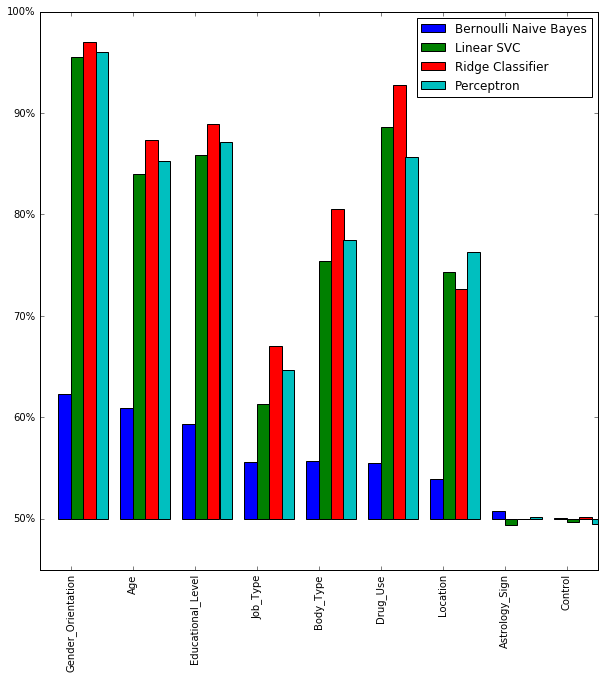

In [70]:
#Matplotlib horizontal bar plot:
#indices = np.arange(num_features)
#plt.figure(figsize=(10, 8))
#plt.title("Classification Scores")
#plt.barh(indices + .6, bnb_scores, .2, label=classifier_names[0], color='purple')
#plt.barh(indices + .4, svm_scores, .2, label=classifier_names[1], color='navy')
#plt.barh(indices + .2, ridge_scores, .2, label=classifier_names[2], color='c')
#plt.barh(indices, percept_scores, .2, label=classifier_names[3], color='darkorange')
#plt.yticks(())
#plt.legend(loc='best')
#plt.subplots_adjust(left=.25)
#plt.subplots_adjust(top=.95)
#plt.subplots_adjust(bottom=.05)
#plt.ylim([-0.05,0.5])
#for i, c in zip(indices, feature_names):
#    plt.text(-.3, i, c)
#plt.show()

#Pandas plot of same, but vertical and with y-axis re-centered at 50%:
classification_results_centered = classification_results - 0.5
ax = classification_results_centered.plot(kind='bar',ylim=[-.05,0.5],figsize=(10,10))
ax.set_yticklabels(['40%','50%','60%','70%','80%','90%','100%'])
#Iterate over each bar and change its width and location:
for container_index, container in enumerate(ax.containers): #http://matplotlib.org/users/artists.html
    for artist_index, artist in enumerate(container):
        plt.setp(artist,width=0.2,x=artist_index+(container_index*0.2)-0.2)